# Jupyter Notebook for Neuroblastoma classifier models using RNA Seq data.
### Author - Muthukumaraswami Sivaswami (1833616)



This analysis was done on a local machine running Python 3.11.8. Please ensure that you have the right version of Python installed on your machine, so that all the required libraries are installed and can be imported.

First, let's take a look at log2FPKM.tsv. This file contains Normalized FPKM/transcript per million (TPM) values in log2 scale. This will be our main expression data file for analysis.

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#importing the log2FPKM.tsv file, containing the RNA Seq data
log2FPKM_df = pd.read_csv('log2FPKM.tsv', sep='\t').rename({'00gene_id':'gene_id'},axis=1)

Now, let's run some sanity checks and look at the data.

In [3]:
#checking the shape of the data
print(f'log2FPKM_df shape: {log2FPKM_df.shape}') 

log2FPKM_df shape: (23146, 499)


We can see that our data has 23146 rows and 499 columns. Let's take a look at the first 5 rows of the data.

In [4]:
#checking the first few rows
log2FPKM_df.head()

,gene_id,NB001,NB002,NB003,NB004,NB005,NB006,NB007,NB008,NB009,...,NB489,NB490,NB491,NB492,NB493,NB494,NB495,NB496,NB497,NB498
0,1/2-SBSRNA4,0.834381,0.743094,0.909414,0.795775,0.905540,0.869154,1.811352,0.599240,0.981855,...,0.997977,1.003559,0.842437,1.057873,0.805515,0.491331,0.868249,0.911379,0.660139,1.152988
1,A1BG,1.910053,0.941996,1.950857,1.989477,1.942946,1.927608,1.617745,2.161291,1.436439,...,2.336929,2.836360,1.205317,2.439868,1.649027,1.451425,1.493852,1.641241,1.994978,1.289534
2,A1BG-AS1,1.453191,0.640614,1.156765,1.525277,1.365043,0.899212,1.304178,1.189205,0.771248,...,1.182908,1.367371,0.643751,1.096815,0.925425,0.933275,1.208723,0.904511,1.529221,1.102866
3,A1CF,0.005102,0.005902,0.005192,0.000000,0.025347,0.005682,0.000000,0.000000,0.021880,...,0.024298,0.007295,0.000000,0.006678,0.005746,0.004998,0.004853,0.000000,0.022780,0.018720
4,A2LD1,0.580151,0.738233,0.927667,0.936497,0.924853,0.739038,1.018705,0.546324,0.666877,...,0.673627,1.401265,0.837443,0.939849,0.743496,0.957837,0.812093,0.488748,1.068072,0.782887


This shows that the first column is simply sample IDs. It is not relevant for our analysis, so we will ignore it, for now.

Now, let's inspect the data by info.

In [5]:
log2FPKM_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23146 entries, 0 to 23145
Columns: 499 entries, gene_id to NB498
dtypes: float64(498), object(1)
memory usage: 88.1+ MB


In [6]:
#checking for missing values
log2FPKM_df.isnull().sum()

gene_id    0
NB001      0
NB002      0
NB003      0
NB004      0
          ..
NB494      0
NB495      0
NB496      0
NB497      0
NB498      0
Length: 499, dtype: int64

Our data has no missing values, which is great for a more robust downstream analysis.

Let's now do a little exploration of the data. We can start by looking at a correlation matrix.

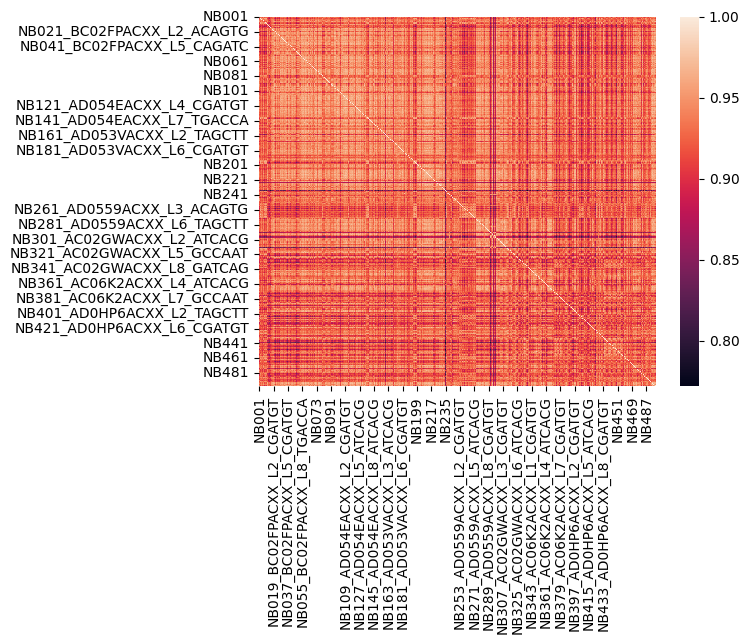

In [7]:
# Set index  
log2FPKM_df.set_index('gene_id', inplace=True)

# Calculate correlation directly
corr = log2FPKM_df.corr() 

# Heatmap  
sns.heatmap(corr)
plt.savefig('corr_heatmap.png')

The correlation values across most gene pairs appear normally distributed around 0 as expected, with no widespread strong correlations. This indicates good variability in the data.

Highly correlated genes are not obvious, which could signify technical artifacts like batch effects from sequencing or sample handling. The correlations appear randomly distributed and mixed.

Overall the heatmap provides confidence that the data is clean and ready for further analysis.

Next, let's just plot the data to see if there are any outliers.
I'll be using tSNE, which is particularly useful in visualizing data with high dimensionality.

# Unsupervised Analysis of RNA Seq data

Let's analyse the data using unsupervised analysis, to find any patterns. I will be using t-SNE, PCA and k-means to analyse the data.

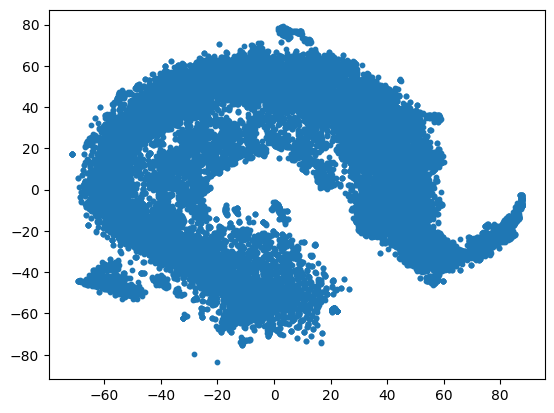

In [8]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0).fit_transform(log2FPKM_df) 

plt.scatter(tsne[:,0], tsne[:,1], s=10)
plt.savefig('tsne.png')

The plot shows that there is one cluster of data, with only one cluster of outliers. The plot doesn't really indicate any meaningful pattern in the data, unfortunately.

I'll try and change the perplexity value and learning rate to see how that affects the plot.

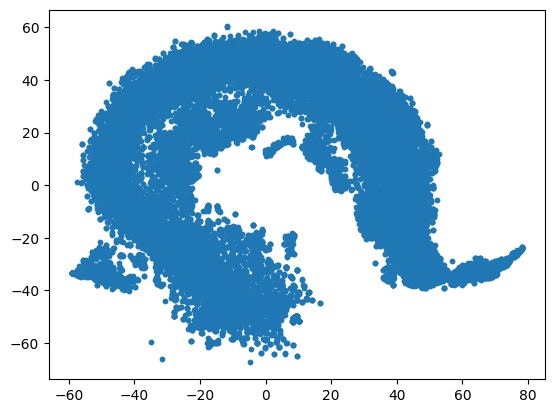

In [9]:
tsne = TSNE(n_components=2,perplexity=50,learning_rate=400, random_state=0).fit_transform(log2FPKM_df) 

plt.scatter(tsne[:,0], tsne[:,1], s=10)
plt.savefig('tsne2.png')

I'll try running a PCA to see if that works better.

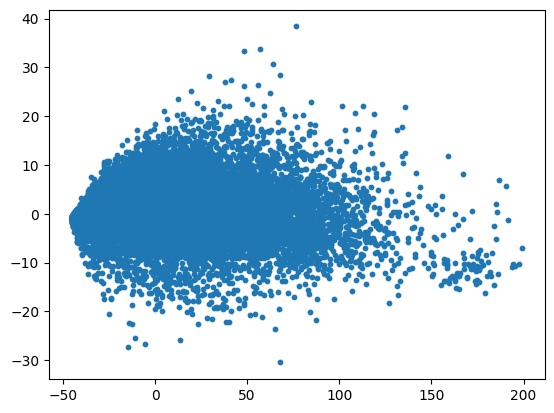

In [10]:
#PCA analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(log2FPKM_df)
plt.scatter(pca_result[:, 0], pca_result[:, 1], s=10)
plt.savefig('pca_log2FPKM.png')

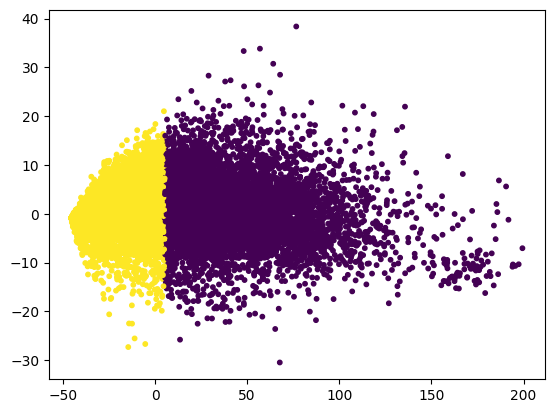

In [11]:
#trying k-means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=1).fit(log2FPKM_df)
kmeans.labels_

#plotting the clusters
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans.labels_, s=10)
plt.savefig('kmeans_log2FPKM.png')


The data doesn't seem to have any patterns.

In [12]:
#importing patientInfo.tsv
patientInfo_df = pd.read_csv('patientInfo.tsv', sep='\t')

Let's do our usual sanity checks.

In [13]:
#checking the shape of the clinical data
print(f'patientInfo_df shape: {patientInfo_df.shape}')

patientInfo_df shape: (498, 7)


We can see that the data has 498 samples, as mentioned in the abstract, and 7 columns. Let's look at the head of the data.

In [14]:
patientInfo_df.head

<bound method NDFrame.head of         ID FactorValue..Sex.  FactorValue..age.at.diagnosis.  \
0    NB498            female                             530   
1    NB497            female                             379   
2    NB496              male                             132   
3    NB495              male                             163   
4    NB494              male                              56   
..     ...               ...                             ...   
493  NB005            female                             536   
494  NB004            female                             335   
495  NB003            female                             625   
496  NB002              male                            1808   
497  NB001              male                             987   

     FactorValue..death.from.disease.  FactorValue..high.risk.  \
0                                 NaN                      NaN   
1                                 0.0                      0.0   
2  

Let's print all the columns to look at what the metadata is.

In [15]:
#printing column labels in patientInfo_df
print(patientInfo_df.columns)

Index(['ID', 'FactorValue..Sex.', 'FactorValue..age.at.diagnosis.',
       'FactorValue..death.from.disease.', 'FactorValue..high.risk.',
       'FactorValue..inss.stage.', 'FactorValue..progression.'],
      dtype='object')


We can see that the metadata given to us includes: <br>
- ID
- Sex
- Age at Diagnosis (in days)
- Death
- High Risk
- INSS Stage
- Progression to a tumour

Moving on to the training data...

In [16]:
#importing the patientInfo_train.tsv file
patientInfo_train_df = pd.read_csv('patientInfo_train.tsv', sep='\t')

Let's do our usual sanity checks.

In [17]:
#checking the shape of the data
print(f'patientInfo_train_df shape: {patientInfo_train_df.shape}') 

patientInfo_train_df shape: (249, 7)


In [18]:
#Now, let's inspect the data
patientInfo_train_df.head

<bound method NDFrame.head of         ID FactorValue..Sex.  FactorValue..age.at.diagnosis.  \
0    NB497            female                             379   
1    NB495              male                             163   
2    NB493              male                             190   
3    NB491              male                            2326   
4    NB489            female                             865   
..     ...               ...                             ...   
244  NB009            female                             217   
245  NB007              male                             942   
246  NB005            female                             536   
247  NB003            female                             625   
248  NB001              male                             987   

     FactorValue..death.from.disease.  FactorValue..high.risk.  \
0                                   0                        0   
1                                   0                        0   
2  

Let's now look for any missing values in the data.

In [19]:
#checking for missing values
patientInfo_train_df.isnull().sum()

ID                                  0
FactorValue..Sex.                   0
FactorValue..age.at.diagnosis.      0
FactorValue..death.from.disease.    0
FactorValue..high.risk.             0
FactorValue..inss.stage.            0
FactorValue..progression.           0
dtype: int64

There are no missing values in the data. This makes our data more robust and ready for further analysis.

Let's now combine the log2FPKM_df and patientInfo_test_df dataframes into a single dataframe.

This new dataframe will be used to build the machine learning models.

In [20]:
#reloading the data
expr = pd.read_csv('log2FPKM.tsv', sep= '\t',index_col=0) 
clinical = pd.read_csv('patientInfo_train.tsv', sep='\t')

# Transpose expression data 
expr = expr.T 

# Reset index to make it a column 
expr = expr.reset_index()
expr = expr.rename(columns={'index':'ID'}) 



The expr dataframe has lots of samples named differently than the clinical dataframe. Let's normalise the labels so that when merged, it does so properly.

In [21]:
#renaming the samples in expression data
expr['ID'] = expr['ID'].str.replace(r'NB(\d+)_.*', r'NB\1', regex=True)

In [22]:
#checking the dataframe to make sure it looks as expected.
expr.head

<bound method NDFrame.head of 00gene_id     ID  1/2-SBSRNA4      A1BG  A1BG-AS1      A1CF     A2LD1  \
0          NB001     0.834381  1.910053  1.453191  0.005102  0.580151   
1          NB002     0.743094  0.941996  0.640614  0.005902  0.738233   
2          NB003     0.909414  1.950857  1.156765  0.005192  0.927667   
3          NB004     0.795775  1.989477  1.525277  0.000000  0.936497   
4          NB005     0.905540  1.942946  1.365043  0.025347  0.924853   
..           ...          ...       ...       ...       ...       ...   
493        NB494     0.491331  1.451425  0.933275  0.004998  0.957837   
494        NB495     0.868249  1.493852  1.208723  0.004853  0.812093   
495        NB496     0.911379  1.641241  0.904511  0.000000  0.488748   
496        NB497     0.660139  1.994978  1.529221  0.022780  1.068072   
497        NB498     1.152988  1.289534  1.102866  0.018720  0.782887   

00gene_id       A2M     A2ML1     A2MP1    A4GALT  ...    ZWILCH     ZWINT  \
0          5.13

expr has a lot of genes with 0 expression. This is likely NaN values that have been coded as 0. Let's remove columns with lots of zeros.

In [23]:
#removing columns with lots of 0 from expr
#Calculate the percentage of zeroes in each column
zero_percentage = expr.eq(0).mean()

#Set a threshold for the percentage of zeroes
threshold = 0.9  # For example, columns with more than 90% zeroes

#Get the column names where the percentage of zeroes exceeds the threshold
columns_to_drop = zero_percentage[zero_percentage > threshold].index

#Drop the columns from the dataframe
expr_filtered = expr.drop(columns=columns_to_drop)



In [24]:
# Merge on PatientID  
merged = clinical.merge(expr_filtered, on='ID')

Let's look at this data and do our regular sanity checks.

In [25]:
#checking the shape of the merged data
print(f'merged data shape: {merged.shape}')

merged data shape: (249, 20303)


The dataframe has all the samples we need, but it's not sorted by PatientID. Let's sort it and fix the indexing.

In [26]:
# Sort by column: 'ID' (ascending)
merged = merged.sort_values(['ID'])
#fixing the index
merged = merged.reset_index(drop=True)

Let's now save the dataframe.

In [27]:
#saving the merged data as a tsv file
merged.to_csv('merged.tsv', sep='\t')

Let's also rename the columns to make them more readable, like before.

In [28]:
#renaming the columns in merged.tsv to make them readable
column_map = {'FactorValue..Sex.': 'Sex',
             'FactorValue..age.at.diagnosis.': 'Age',
             'FactorValue..death.from.disease.': 'Death',
             'FactorValue..high.risk.': 'High Risk',
             'FactorValue..inss.stage.': 'INSS',
             'FactorValue..progression.': 'Progression'}

#reading the merged data as a dataframe
merged_df = pd.read_csv('merged.tsv', sep='\t')

merged_df = merged_df.rename(columns=column_map)
#dropping an extra column that was generated
merged_df = merged_df.drop(['Unnamed: 0'], axis=1)

#replacing male with 1 and female with 0
merged_df['Sex'] = merged_df['Sex'].replace({'male': 1, 'female': 0})


C:\Users\Muthu\AppData\Local\Temp\ipykernel_18636\1640842000.py:10: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv('merged.tsv', sep='\t')


Let's look at the merged data and do our usual sanity checks.

In [29]:
#checking the shape of the merged data
print(f'merged data shape: {merged_df.shape}')
#checking for missing values
merged_df.isnull().sum()
#printing the first few rows
merged_df.head

merged data shape: (249, 20303)


<bound method NDFrame.head of         ID  Sex   Age  Death  High Risk INSS  Progression  1/2-SBSRNA4  \
0    NB001    1   987      1          1    4            1     0.834381   
1    NB003    0   625      1          1    4            1     0.909414   
2    NB005    0   536      1          1    4            1     0.905540   
3    NB007    1   942      0          1    4            1     1.811352   
4    NB009    0   217      0          1   4S            0     0.981855   
..     ...  ...   ...    ...        ...  ...          ...          ...   
244  NB489    0   865      0          1    4            0     0.997977   
245  NB491    1  2326      0          1    4            1     0.842437   
246  NB493    1   190      0          0    1            0     0.805515   
247  NB495    1   163      0          0    1            0     0.868249   
248  NB497    0   379      0          0    1            0     0.660139   

         A1BG  A1BG-AS1  ...    ZWILCH     ZWINT      ZXDA      ZXDB  \
0    1.91

Now that we have our dataset, let's look at building models.

We need to build classifier models for each of the clinical outcomes, namely: 
- Death 
- High Risk 
- INSS stage
- Progression to a tumour

Let's start with death.

In [30]:
#building a classifier model for the merged data

#First, let's split the data into features and target

X = merged_df.drop('Death', axis=1)
# Columns to remove
cols_to_drop = ['ID', 'Sex', 'Age','Death', 'High Risk', 'INSS', 'Progression'] 

# Drop columns
X = merged_df.drop(cols_to_drop, axis=1)  
y = merged_df['Death']  

Let's scale our feature data.

In [32]:
#let's find the most significant features using Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier().fit(X, y)
importances = rf.feature_importances_

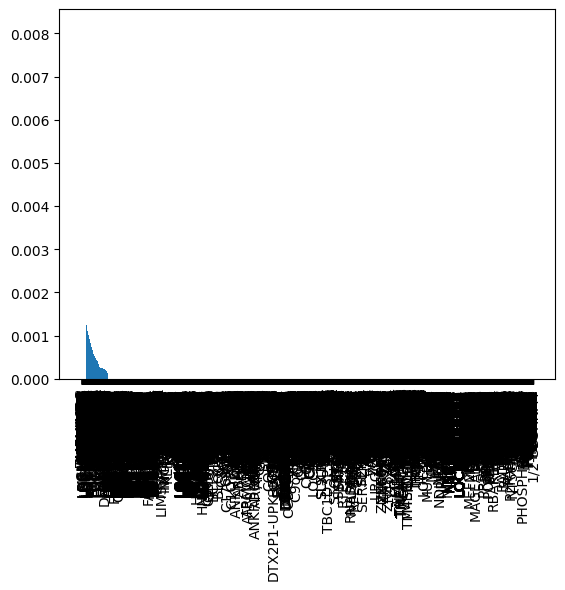

In [33]:
#let's now find the most important features
indices = np.argsort(importances)[::-1]
features = X.columns
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
#saving the plot
plt.savefig('feature_importance_1.png')

plt.show()


Well, that plot is too difficult to read, and doesn't help with our analysis. Let's try a different approach.

In [34]:
feat_imp_death = pd.DataFrame({'feature':features, 
                         'importance':importances}).sort_values(by='importance', ascending=False)

top20_death = feat_imp_death[:20]

print(top20_death)

         feature  importance
16574     SMNDC1    0.008158
12593      NUDT5    0.006244
3247       CDCA4    0.006241
5497      ERCC6L    0.006220
5672     FAM104B    0.006091
2140     C1orf63    0.006050
3511        CHD5    0.005999
6405       FLOT2    0.005774
12193     NEURL4    0.005633
18013   TMEM191C    0.004617
7138        GPN3    0.004443
13200       PCNA    0.004269
6192      FERMT2    0.004258
10447  LOC728606    0.004224
3491       CHAC2    0.004197
10789     MAD2L1    0.004108
579         AMD1    0.004092
18796      UBE2A    0.004075
11891     NAP1L1    0.004045
2960      CCDC34    0.003966


Let's also identify the most significant statistics for death using univariate analysis.

In [35]:
#importing libraries
from scipy import stats 
from sklearn.feature_selection import f_classif, chi2

In [36]:
f_values, p_values = f_classif(X, y)
chi2_values, p_chi2_values = chi2(X, y)

In [37]:
f_results = pd.DataFrame({'feature':X.columns, 
                          'f_value':f_values, 
                          'p_value':p_values})

chi2_results = pd.DataFrame({'feature':X.columns,  
                             'chi2':chi2_values,
                             'p_chi2':p_chi2_values})

In [38]:
f_results.sort_values(by='p_value', ascending=True) 
chi2_results.sort_values(by='p_chi2', ascending=True)

,feature,chi2,p_chi2
7905,HOXD11,1.088040e+02,1.791580e-25
12989,PAGE5,8.571689e+01,2.076322e-20
11752,MYCNOS,8.295037e+01,8.413943e-20
16693,SNORA76,7.920808e+01,5.590104e-19
11949,NCAN,7.130744e+01,3.056805e-17
...,...,...,...
18920,UHRF1BP1,4.186300e-08,9.998367e-01
6583,FURIN,4.023109e-08,9.998400e-01
7979,HSD3B1,2.434674e-08,9.998755e-01
4136,CSF2,1.262221e-08,9.999104e-01


In [39]:
f_results.sort_values(by='p_value', ascending=True, inplace=True)
chi2_results.sort_values(by='p_chi2', ascending=True, inplace=True)

f_top20 = f_results.head(20)  
chi2_top20 = chi2_results.head(20)

f_features = list(f_top20['feature'])
chi2_features = list(chi2_top20['feature'])

In [40]:
f_features

['CNIH4',
 'DKC1',
 'ACTL6A',
 'ERCC6L',
 'PPID',
 'WSB1',
 'CES4A',
 'HNRNPC',
 'SNAPC1',
 'CROCCP3',
 'KIF18A',
 'MRPL11',
 'TOM1L2',
 'PDHA1',
 'MAP3K12',
 'CSRP2',
 'ACN9',
 'MRPL3',
 'GMPS',
 'MAD2L1']

Clearly, the features vary between models. Let's build a full Logistic Regression model, and check it's performance.

In [41]:
#importing libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Creating a logistic regression model
logmodel_death = LogisticRegression(max_iter=1000)

#Training the model on the training data
logmodel_death.fit(X_train, y_train)

#Making predictions on the test data
y_pred = logmodel_death.predict(X_test)

#Checking the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

#Evaluating the model
print(classification_report(y_test, y_pred))


Accuracy: 0.76
              precision    recall  f1-score   support

           0       0.81      0.90      0.85        39
           1       0.43      0.27      0.33        11

    accuracy                           0.76        50
   macro avg       0.62      0.59      0.59        50
weighted avg       0.73      0.76      0.74        50



Let's look at the confusion matrix and ROC curve.

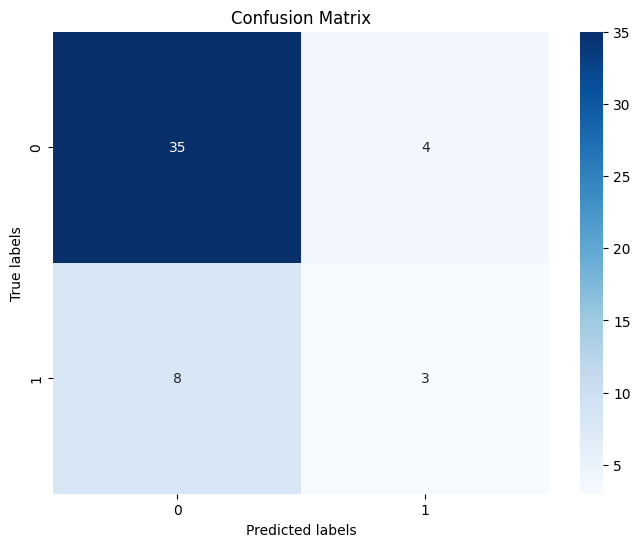

In [42]:
#importing libraries
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

#saving the plot
plt.savefig('confusion_matrix_logreg_death.png')

plt.show()



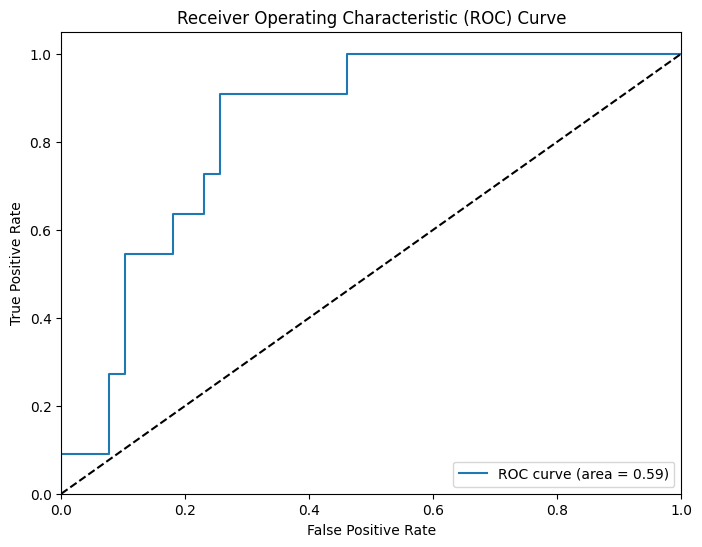

In [43]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, logmodel_death.predict_proba(X_test)[:,1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

#saving the plot
plt.savefig('roc_curve_logreg_death.png')

plt.show()



Area of 0.59 isn't great. but I want to try hyperparameter tuning. I tried using GridSearchCV, but the runtime was longer than an hour. Due to that, I'll try using RandomizedSearchCV instead, as it is known to be faster for large datasets. This did not prove fruitful as I kept running into convergence errors, even at 1000 iters. Due to this, I decided to move onto a different model. The code for the RandomizedSearchCV can be found below, but I've commented it out, just so that it can be observed, or for reference.

In [44]:
# #importing libraries
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import uniform
# #Defining the hyperparameter distributions
# param_dist = {
#     'C': uniform(0.01, 100),  # Uniform distribution between 0.01 and 100
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear', 'saga']
# }
# #Creating the RandomizedSearchCV object
# random_search = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_dist, n_iter=1000, cv=5)
# #Performing the randomized search on the training data
# random_search.fit(X_train, y_train)
# #Getting the best hyperparameters
# best_params = random_search.best_params_
# print("Best Hyperparameters:", best_params)
# # Assuming random_search is your RandomizedSearchCV object
# best_params = random_search.best_params_

# #Creating a logistic regression model with the best hyperparameters
# best_model = LogisticRegression(**best_params, max_iter=1000)

# #Training the model
# best_model.fit(X_train, y_train)

# #Making predictions
# y_pred = best_model.predict(X_test)

# #Evaluating the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")


Let's try building a decision tree classifier model.

In [45]:
#importing libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [46]:
#splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [47]:
#Creating the decision tree model
tree_model_death = DecisionTreeClassifier()

In [48]:
#Training the model
tree_model_death.fit(X_train, y_train)

DecisionTreeClassifier()

In [49]:
#Making predictions on the test data
y_pred = tree_model_death.predict(X_test)

In [50]:
#Calculating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.76
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        39
           1       0.46      0.55      0.50        11

    accuracy                           0.76        50
   macro avg       0.66      0.68      0.67        50
weighted avg       0.78      0.76      0.77        50



Let's also visualise the tree.

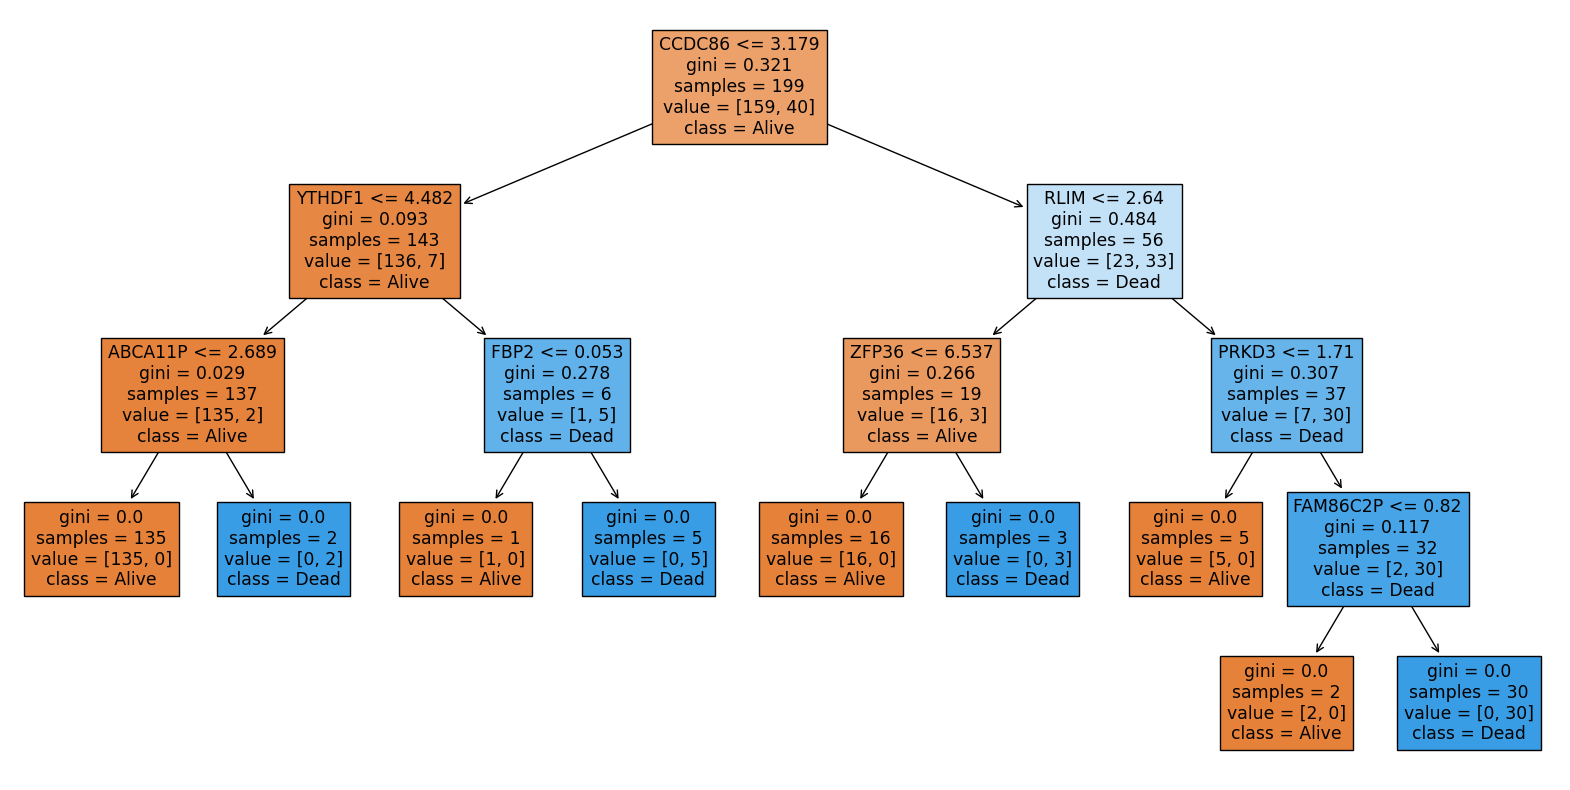

In [51]:
#Plotting the decision tree
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(tree_model_death, filled=True, feature_names=X.columns, class_names=['Alive', 'Dead'])

#saving the plot
plt.savefig('decision_tree_death.png')

plt.show()



Next, I'll try a support vector classifier.

In [52]:
#importing libraries
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [53]:
#splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Creating an SVC model
svc_model_death = SVC()

In [54]:
#Training the model
svc_model_death.fit(X_train, y_train)

#Making predictions on the test data
y_pred = svc_model_death.predict(X_test)

In [55]:
#Calculating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        39
           1       0.00      0.00      0.00        11

    accuracy                           0.78        50
   macro avg       0.39      0.50      0.44        50
weighted avg       0.61      0.78      0.68        50



C:\Users\Muthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Muthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Muthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

The Support Vector Classifier model has a decent accuracy of 78%. I'll move on to looking at one of the other labels.

Next, I'll be looking at building models to predict the chance of a patient being considered high risk.


First, I'll try logistic regression.

In [56]:
#First, let's split the data into features and target
X = merged_df.drop('High Risk', axis=1)
# Columns to remove
cols_to_drop = ['ID', 'Sex', 'Age','Death','High Risk','INSS', 'Progression'] 

# Drop columns
X = merged_df.drop(cols_to_drop, axis=1)  
y = merged_df['High Risk']  

In [57]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [58]:
logmodel_risk = LogisticRegression()
logmodel_risk.fit(X_train, y_train)

LogisticRegression()

In [59]:
y_pred = logmodel_risk.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

              precision    recall  f1-score   support

           0       0.94      0.91      0.93        34
           1       0.82      0.88      0.85        16

    accuracy                           0.90        50
   macro avg       0.88      0.89      0.89        50
weighted avg       0.90      0.90      0.90        50

Accuracy: 0.9


Great! The accuracy of this model is 90% Let's now look at the confusion matrix and ROC curve of this model.

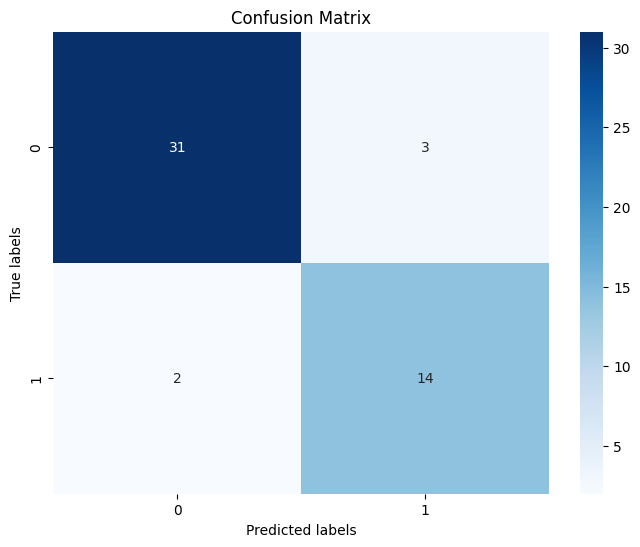

In [60]:
#Plotting the confusion matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

#saving the plot
plt.savefig('confusion_matrix_logreg_risk.png')

plt.show()

In [61]:
# Calculate ROC curve and AUC
y_pred_proba = logmodel_risk.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

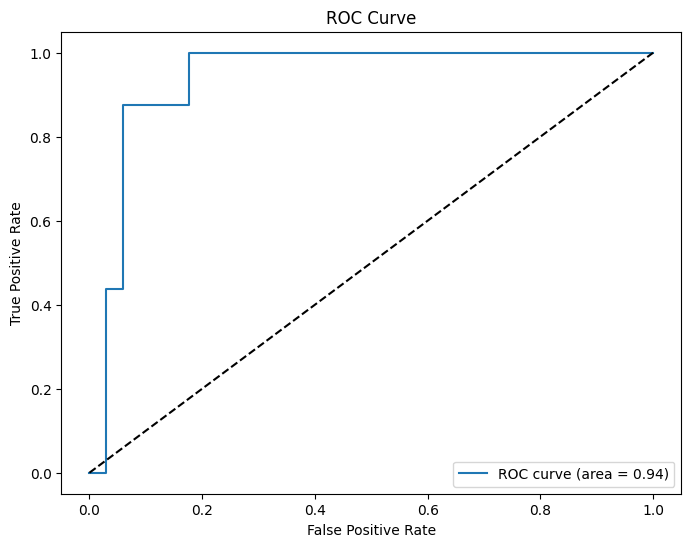

In [62]:
#Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

#saving the plot
plt.savefig('roc_curve_logreg_risk.png')

plt.show()

Next, I'll try a decision tree.

In [63]:
#importing libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [64]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [65]:
#Creating a decision tree model
treemodel_risk = DecisionTreeClassifier()

#Training the model
treemodel_risk.fit(X_train, y_train)

#Making predictions
y_pred = treemodel_risk.predict(X_test)

#Printing the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90        34
           1       0.76      0.81      0.79        16

    accuracy                           0.86        50
   macro avg       0.84      0.85      0.84        50
weighted avg       0.86      0.86      0.86        50



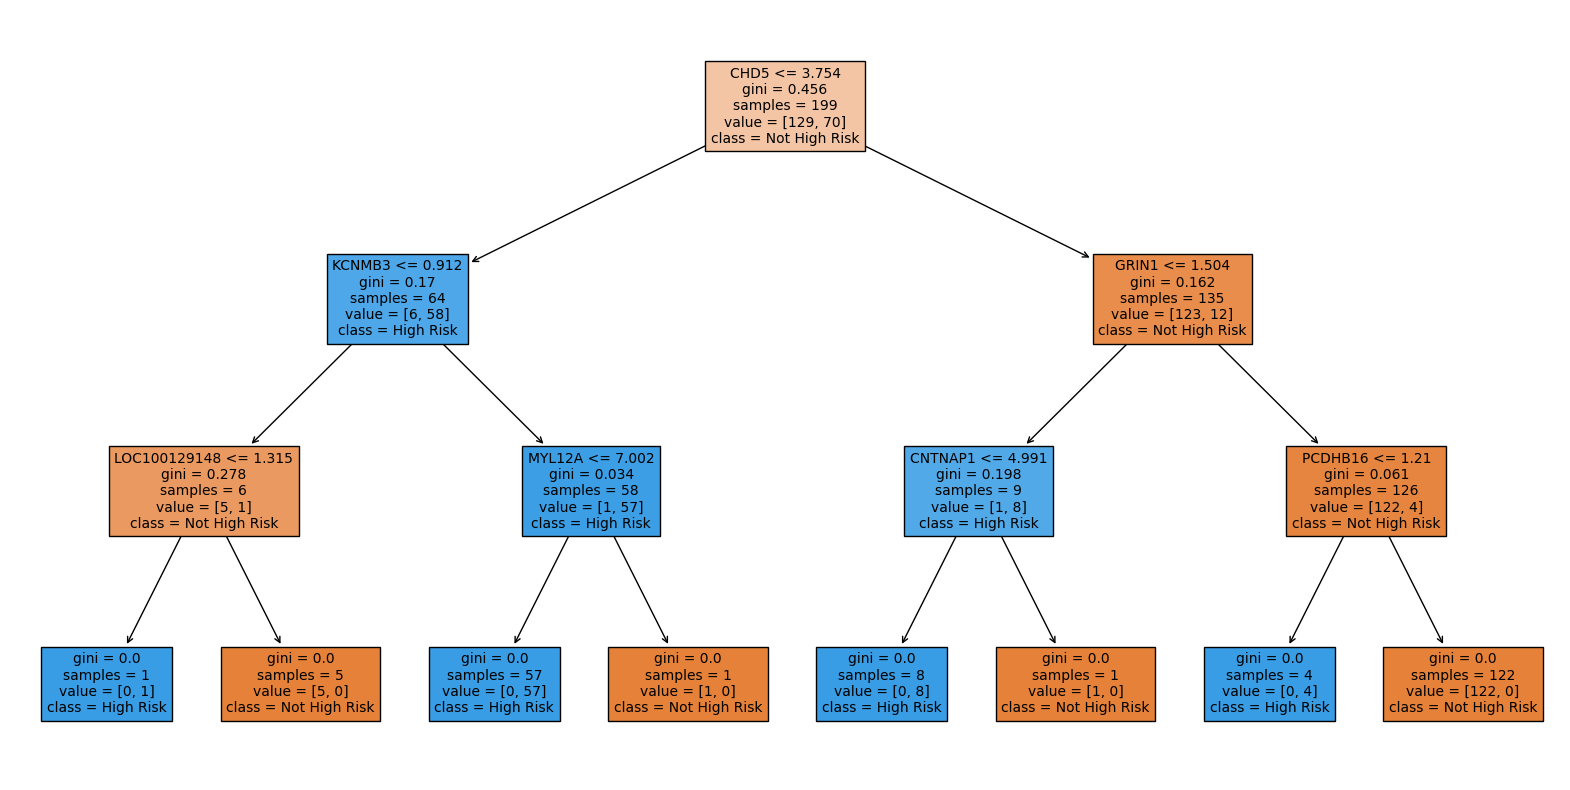

In [66]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

#Creating a figure and set its size
plt.figure(figsize=(20, 10))

# Plot the decision tree
plot_tree(treemodel_risk, feature_names=X.columns, class_names=['Not High Risk', 'High Risk'], filled=True, fontsize=10)

# Saving the plot
plt.savefig('decision_tree_risk.png')

# Display the plot
plt.show()

In [67]:
#loading libraries
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

#Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Creating an SVM model
svm_model_risk = SVC()

#Training the model
svm_model_risk.fit(X_train, y_train)

#Making predictions on the test data
y_pred = svm_model_risk.predict(X_test)

#Printing the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89        34
           1       0.79      0.69      0.73        16

    accuracy                           0.84        50
   macro avg       0.82      0.80      0.81        50
weighted avg       0.84      0.84      0.84        50



Let's now look at building models to predict the chances of progression to a tumour.

As usual, let's first assign the features and the target variable.

In [68]:
X = merged_df.drop('Progression', axis=1)
# Columns to remove
cols_to_drop = ['ID', 'Sex', 'Age','Death','Progression', 'High Risk', 'INSS'] 

# Drop columns
X = merged_df.drop(cols_to_drop, axis=1)  
y = merged_df['Progression']  

Now, let's build a logistic regression model.

In [69]:
#splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Creating a logistic regression model
logreg_progression_model = LogisticRegression(max_iter=1000)

#Training the model on the training data
logreg_progression_model.fit(X_train, y_train)

#Making predictions on the test data
y_pred = logreg_progression_model.predict(X_test)

#Checking the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.76
              precision    recall  f1-score   support

           0       0.76      0.86      0.81        29
           1       0.76      0.62      0.68        21

    accuracy                           0.76        50
   macro avg       0.76      0.74      0.75        50
weighted avg       0.76      0.76      0.76        50



Let's now visualise the confusion matrix and ROC curve.

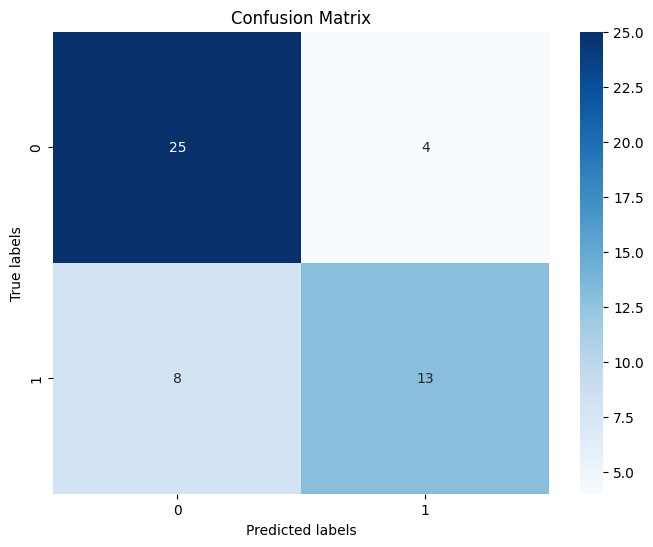

In [70]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

#saving the plot
plt.savefig('confusion_matrix_logreg_progression.png')

plt.show()

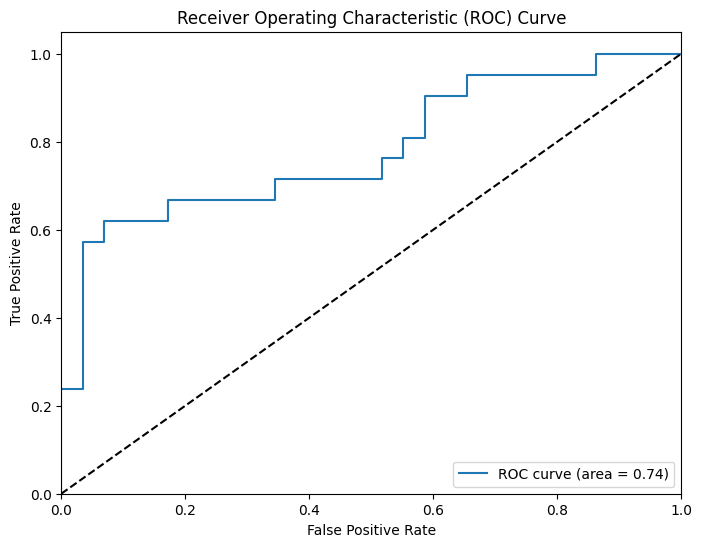

In [71]:
#Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, logreg_progression_model.predict_proba(X_test)[:,1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

#saving the plot
plt.savefig('roc_curve_logreg_progression.png')

plt.show()

In [72]:
#Evaluating the model performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81        29
           1       0.76      0.62      0.68        21

    accuracy                           0.76        50
   macro avg       0.76      0.74      0.75        50
weighted avg       0.76      0.76      0.76        50



Next, let's try a decision tree model.

In [73]:
#splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Creating a decision tree model
treemodel_progression = DecisionTreeClassifier()

#Training the model
treemodel_progression.fit(X_train, y_train)

#Making predictions
y_pred = treemodel_progression.predict(X_test)

#Printing the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.69      0.65        29
           1       0.47      0.38      0.42        21

    accuracy                           0.56        50
   macro avg       0.54      0.54      0.53        50
weighted avg       0.55      0.56      0.55        50



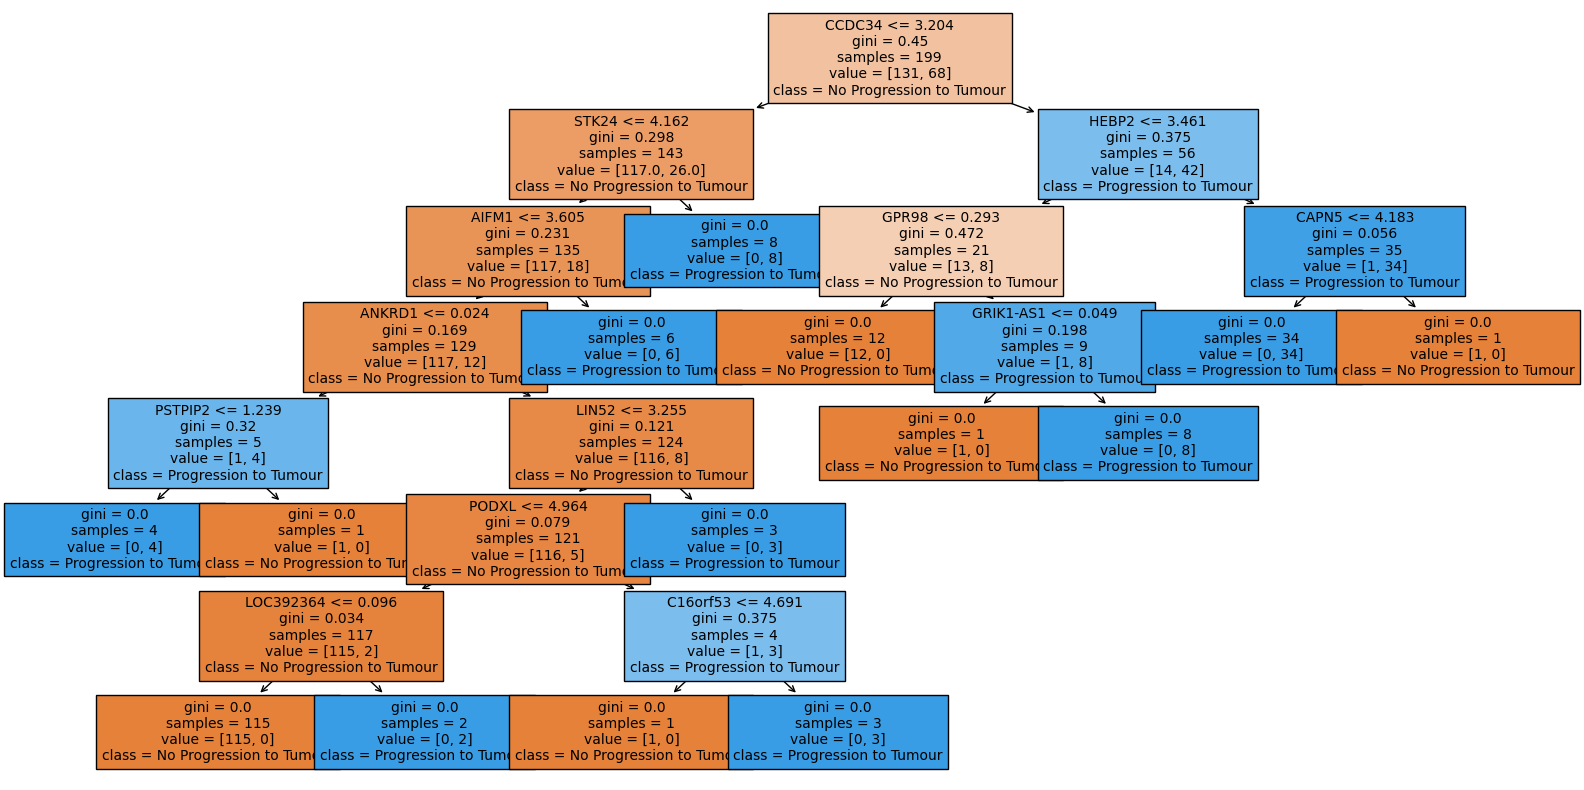

In [74]:
#Creating a figure and set its size
plt.figure(figsize=(20, 10))

# Plot the decision tree
plot_tree(treemodel_progression, feature_names=X.columns, class_names=['No Progression to Tumour', 'Progression to Tumour'], filled=True, fontsize=10)

# Saving the plot
plt.savefig('decision_tree_risk.png')

# Display the plot
plt.show()

Let's try support vector machines.

In [75]:
#Creating an SVM model
svm_model_progression = SVC()

#Training the model
svm_model_progression.fit(X_train, y_train)

#Making predictions on the test data
y_pred = svm_model_progression.predict(X_test)

#Printing the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.90      0.73        29
           1       0.62      0.24      0.34        21

    accuracy                           0.62        50
   macro avg       0.62      0.57      0.54        50
weighted avg       0.62      0.62      0.57        50



The INSS Stage is the most complicated in our data. It takes into account surgery to remove a tumour, and evaluates the state of the neuroblastoma in the patient. Let's first look at all the values in the INSS Stage column.

In [76]:
#grouping the INSS column and counting the values
merged_df['INSS'].groupby(merged_df['INSS']).count()

INSS
1     29
2     14
3     18
4     28
1     31
2     26
3     12
4     63
4S    28
Name: INSS, dtype: int64

The documentation says that there are only 5 groups (1, 2, 3, 4 snd 4S), but it seems like there are 9. Let's see if we can group them into 5 groups, with 4S being defined as 5, for simplicity.

In [77]:
#grouping into 5 groups, by merging the groups with the same INSS labels
merged_df['INSS'] = merged_df['INSS'].replace(['1', '2', '3', '4', '1', '2', '3', '4', '4S'], [1, 2, 3, 4, 1, 2, 3, 4, 5])

In [78]:
#grouping the INSS column and counting the values
merged_df['INSS'].groupby(merged_df['INSS']).count()

INSS
1    60
2    40
3    30
4    91
5    28
Name: INSS, dtype: int64

That seems to have fixed the issue. Let's move on to building predictive models.

Due to the INSS Label being a multi-class variable, we cannot use a logistic regression model. Let's try a random forest model.

In [79]:
# Define the mapping of old column names to new column names
X = merged_df.drop('INSS', axis=1)
# Columns to remove
cols_to_drop = ['ID', 'Sex', 'Age','Death', 'High Risk','INSS','Progression'] 

# Drop columns
X = merged_df.drop(cols_to_drop, axis=1)  
y = merged_df['INSS']  

In [80]:
# Splitting the data into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [81]:
# Initialize the Random Forest Classifier
rf_classifier_INSS = RandomForestClassifier(n_estimators=100, random_state=1)

In [82]:
# Train the model on the training data
rf_classifier_INSS.fit(X_train, y_train)
# Make predictions on the test data
y_pred = rf_classifier_INSS.predict(X_test)

In [83]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# Print the classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.5
              precision    recall  f1-score   support

           1       0.29      0.70      0.41        10
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00        10
           4       0.77      0.89      0.83        19
           5       1.00      0.33      0.50         3

    accuracy                           0.50        50
   macro avg       0.41      0.39      0.35        50
weighted avg       0.41      0.50      0.43        50



C:\Users\Muthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Muthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Muthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

The accuracy is too low, let's try a decision tree model.

Accuracy: 0.54

Classification Report:
               precision    recall  f1-score   support

           1       0.27      0.40      0.32        10
           2       0.50      0.50      0.50         8
           3       0.33      0.20      0.25        10
           4       0.94      0.84      0.89        19
           5       0.25      0.33      0.29         3

    accuracy                           0.54        50
   macro avg       0.46      0.46      0.45        50
weighted avg       0.57      0.54      0.55        50


Confusion Matrix:
 [[ 4  2  2  0  2]
 [ 3  4  1  0  0]
 [ 6  2  2  0  0]
 [ 1  0  1 16  1]
 [ 1  0  0  1  1]]


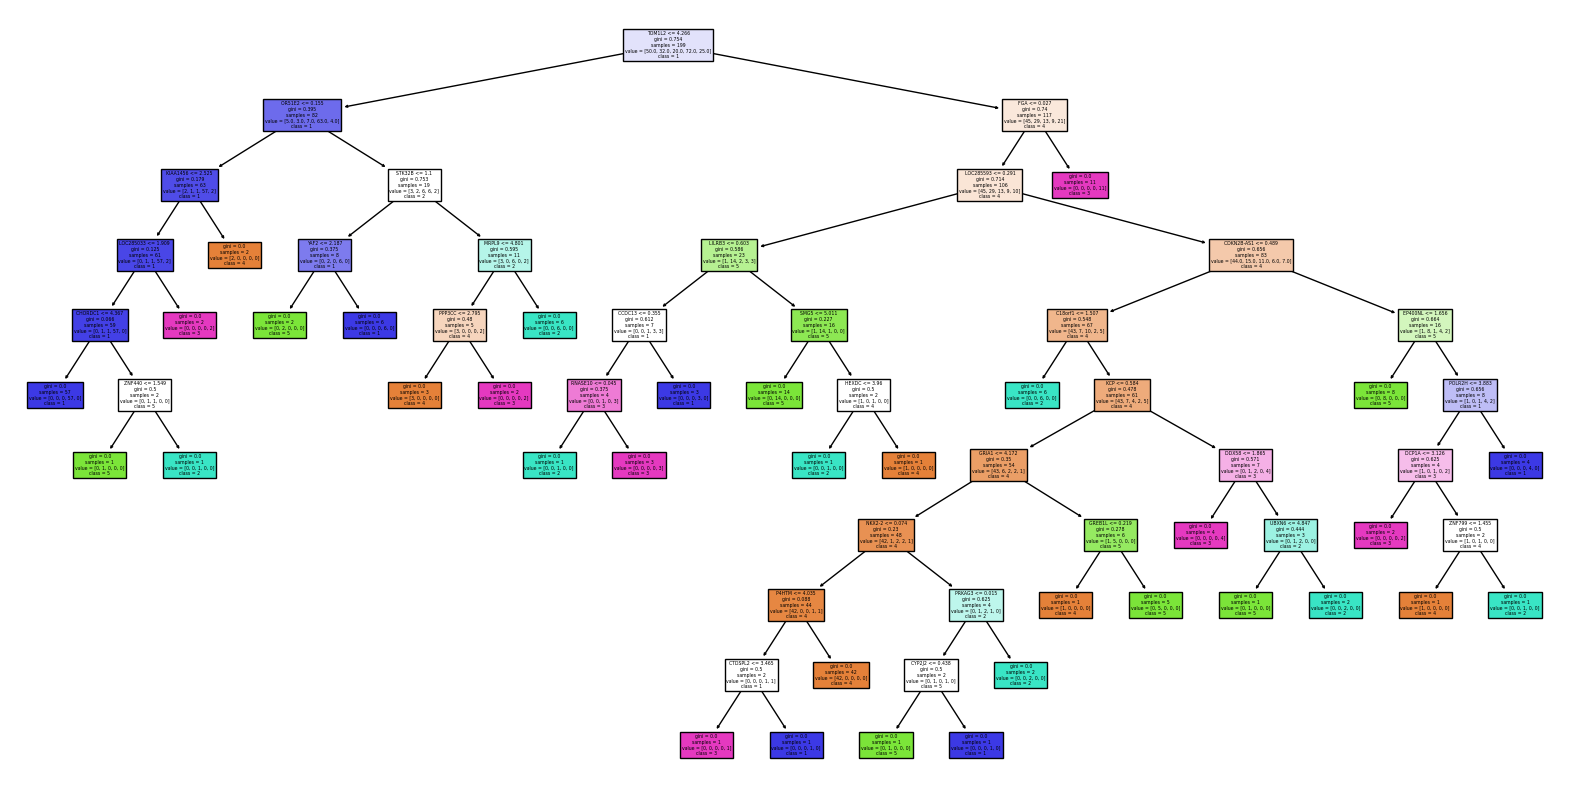

In [84]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Instantiate the Decision Tree Classifier
dt_classifier_INSS = DecisionTreeClassifier(random_state=42)

# Train the Classifier
dt_classifier_INSS.fit(X_train, y_train)

# Make Predictions
y_pred = dt_classifier_INSS.predict(X_test)

# Evaluate the Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualising the Decision Tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Convert y.unique() to strings
class_names = y.unique().astype(str)

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_classifier_INSS, filled=True, feature_names=X.columns, class_names=class_names)

#saving the plot
plt.savefig('decision_tree_INSS.png') 

plt.show()


In [85]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Instantiate the SVC
svc_classifier_INSS = SVC(kernel='rbf', random_state=1)

# Train the Classifier
svc_classifier_INSS.fit(X_train, y_train)

# Make Predictions
y_pred = svc_classifier_INSS.predict(X_test)

# Evaluate the Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.5

Classification Report:
               precision    recall  f1-score   support

           1       0.29      0.80      0.42        10
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00        10
           4       0.77      0.89      0.83        19
           5       0.00      0.00      0.00         3

    accuracy                           0.50        50
   macro avg       0.21      0.34      0.25        50
weighted avg       0.35      0.50      0.40        50



C:\Users\Muthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Muthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Muthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

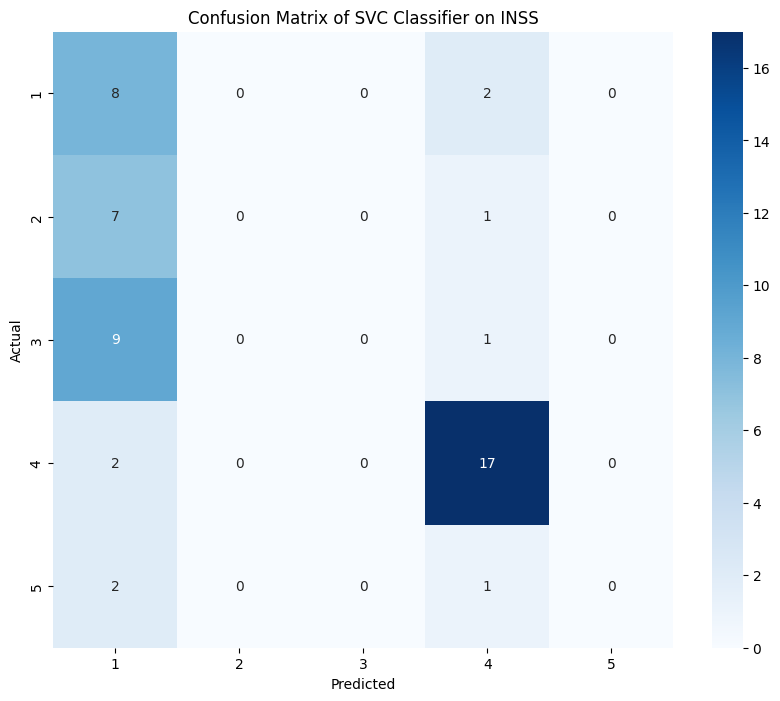

In [86]:
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm, index=svc_classifier_INSS.classes_, columns=svc_classifier_INSS.classes_)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of SVC Classifier on INSS')

#saving the plot
plt.savefig('confusion_matrix_SVclassifier_INSS.png')
plt.show()

This model isn't very reliable. Perhaps we can try a neural network.

In [90]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


# Adjust the class labels to start from 0
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Convert the target variable to categorical
y_train_categorical = to_categorical(y_train_adjusted, num_classes=5)  
y_test_categorical = to_categorical(y_test_adjusted, num_classes=5)    

# Building the neural network model
nn_model_INSS = Sequential()
nn_model_INSS.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
nn_model_INSS.add(Dense(64, activation='relu'))
nn_model_INSS.add(Dense(5, activation='softmax'))  # 5 classes for INSS staging

# Compiling the model
nn_model_INSS.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = nn_model_INSS.fit(X_train, y_train_categorical, epochs=50, batch_size=32, validation_data=(X_test, y_test_categorical))

# Evaluating the model
loss, accuracy = nn_model_INSS.evaluate(X_test, y_test_categorical)
print(f"Test Accuracy: {accuracy}")


Epoch 1/50
7/7 [==============================] - 1s 45ms/step - loss: 48.8881 - accuracy: 0.2211 - val_loss: 30.8447 - val_accuracy: 0.3800
Epoch 2/50
7/7 [==============================] - 0s 23ms/step - loss: 27.4686 - accuracy: 0.2462 - val_loss: 38.8966 - val_accuracy: 0.2000
Epoch 3/50
7/7 [==============================] - 0s 23ms/step - loss: 28.7709 - accuracy: 0.3618 - val_loss: 21.3600 - val_accuracy: 0.4800
Epoch 4/50
7/7 [==============================] - 0s 23ms/step - loss: 11.4025 - accuracy: 0.3116 - val_loss: 4.2746 - val_accuracy: 0.3800
Epoch 5/50
7/7 [==============================] - 0s 24ms/step - loss: 5.8485 - accuracy: 0.3769 - val_loss: 9.0925 - val_accuracy: 0.2600
Epoch 6/50
7/7 [==============================] - 0s 25ms/step - loss: 5.2467 - accuracy: 0.4121 - val_loss: 6.5857 - val_accuracy: 0.2600
Epoch 7/50
7/7 [==============================] - 0s 24ms/step - loss: 3.1541 - accuracy: 0.3668 - val_loss: 3.4176 - val_accuracy: 0.3600
Epoch 8/50
7/7 [====

# Model Selection

Based on the performances of the models, I'm choosing the best performing model for each label.

## Death Prediction
The logistic regression model had the best performance, with an accuracy of 0.76 and f1 score of 0.77. I'll use this model for death prediction.

tree_model_death

## High Risk Prediction
The logistic regression model had the best performance, with an accuracy of 0.90 and f1 score of 0.90. I'll use this model for risk prediction.

logmodel_risk

## Progression to Tumour Prediction
The support vector classifier model had the best performance, with an accuracy of 0.76 and f1 score of 0.77. I'll use this model for progression to tumour prediction.

logreg_progression_model

## INSS Stage Prediction
The neural network model had an accuracy of 56% and the decision tree had an accuracy of 54%. I'll use both models for INSS stage prediction.

nn_model_INSS
dt_classifier_INSS

Let's now build a dataframe with the test data and the RNA Seq data so that we can make predictions.

In [91]:
#first, let's open patientInfo_test.tsv as a dataframe
patientInfo_test_df = pd.read_csv('patientInfo_test.tsv', sep='\t')

In [92]:
# Merge on PatientID  
merged_test = patientInfo_test_df.merge(expr_filtered, on='ID')

In [93]:
# Sort by column: 'ID' (ascending)
merged_test = merged_test.sort_values(['ID'])
#fixing the index
merged_test = merged_test.reset_index(drop=True)

In [94]:
#renaming the columns in merged.tsv to make them readable
column_map2 = {'FactorValue..Sex.': 'Sex',
             'FactorValue..age.at.diagnosis.': 'Age',
             'FactorValue..death.from.disease.': 'Death',
             'FactorValue..high.risk.': 'High Risk',
             'FactorValue..inss.stage.': 'INSS',
             'FactorValue..progression.': 'Progression'}

merged_test = merged_test.rename(columns=column_map2)


In [95]:
#saving the merged dataframe as a tsv file
merged_test.to_csv('merged_test.tsv', sep='\t')

In [96]:
merged_test.head()

,ID,Sex,Age,Death,High Risk,INSS,Progression,1/2-SBSRNA4,A1BG,A1BG-AS1,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,NB002,male,1808,NaN,NaN,NaN,NaN,0.743094,0.941996,0.640614,...,3.617510,5.037365,1.487028,2.748315,3.201112,0.051655,3.595790,5.144157,2.843600,3.052771
1,NB004,female,335,NaN,NaN,NaN,NaN,0.795775,1.989477,1.525277,...,3.699507,4.157084,1.351250,2.447746,3.081720,0.108028,3.312516,6.142091,2.864198,3.119886
2,NB006,male,147,NaN,NaN,NaN,NaN,0.869154,1.927608,0.899212,...,3.577320,4.726079,1.567141,2.373818,3.190773,0.264942,3.459969,6.108395,3.970366,3.074821
3,NB008,male,1652,NaN,NaN,NaN,NaN,0.599240,2.161291,1.189205,...,3.550113,3.800683,1.618957,2.620216,3.262666,0.000000,2.359791,5.018567,2.817902,3.395432
4,NB010,male,379,NaN,NaN,NaN,NaN,1.066399,2.159797,1.114787,...,3.507782,4.289820,0.794625,2.559624,2.931842,0.021898,3.284610,5.730512,2.880292,3.263155


In [107]:
#making a copy of merged_test
merged_test_copy = merged_test.copy()

In [108]:
#deleting Sex, Age, Death, High Risk, INSS, Progression columns
merged_test_copy = merged_test_copy.drop(['ID','Sex', 'Age', 'Death', 'High Risk', 'INSS', 'Progression'], axis=1)
merged_test_copy.head()

,1/2-SBSRNA4,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,0.743094,0.941996,0.640614,0.005902,0.738233,5.116157,0.000000,0.000000,1.038092,0.066125,...,3.617510,5.037365,1.487028,2.748315,3.201112,0.051655,3.595790,5.144157,2.843600,3.052771
1,0.795775,1.989477,1.525277,0.000000,0.936497,6.034460,0.000000,0.044204,1.091341,0.028540,...,3.699507,4.157084,1.351250,2.447746,3.081720,0.108028,3.312516,6.142091,2.864198,3.119886
2,0.869154,1.927608,0.899212,0.005682,0.739038,5.281676,0.000000,0.000000,1.184775,0.032086,...,3.577320,4.726079,1.567141,2.373818,3.190773,0.264942,3.459969,6.108395,3.970366,3.074821
3,0.599240,2.161291,1.189205,0.000000,0.546324,5.221807,0.008817,0.000000,0.798254,0.054667,...,3.550113,3.800683,1.618957,2.620216,3.262666,0.000000,2.359791,5.018567,2.817902,3.395432
4,1.066399,2.159797,1.114787,0.000000,0.865850,4.399096,0.008982,0.000000,0.850427,0.000000,...,3.507782,4.289820,0.794625,2.559624,2.931842,0.021898,3.284610,5.730512,2.880292,3.263155


Now that we're finally ready, let's actually predict the values.

First, I'll make a copy of patientInfo_test.tsv so that I can save the predictions.

In [109]:
#making a copy of patientInfo_test.tsv to make my predictions
patientInfo_test_predictions = patientInfo_test_df.copy()


Predicting Death

In [110]:
#predicting death in the test data
y_pred_test_death = tree_model_death.predict(merged_test_copy)
y_pred_test_death

#saving the predicted values into a new column in merged_test
patientInfo_test_predictions['Death'] = y_pred_test_death

Predicting High Risk

In [111]:
#predicting high risk in the test data
y_pred_test_highrisk = logmodel_risk.predict(merged_test_copy)
y_pred_test_highrisk

#saving the predicted values into a new column in merged_test
patientInfo_test_predictions['Risk'] = y_pred_test_highrisk


Predicting Progression to Tumour

In [112]:
#predicting progression in the test data
y_pred_test_progression = logreg_progression_model.predict(merged_test_copy)
y_pred_test_progression

#saving the predicted values into a new column in merged_test
patientInfo_test_predictions['Progression'] = y_pred_test_progression

Predicting INSS Stage

In [113]:
#predicting INSS in the test data
y_pred_test_INSS = nn_model_INSS.predict(merged_test_copy)
y_pred_test_INSS

#saving the predicted values into a new column in patientInfo_test_predictions
patientInfo_test_predictions['INSS'] = y_pred_test_INSS

8/8 [==============================] - 0s 3ms/step


ValueError: Expected a 1D array, got an array with shape (249, 5)

That doesn't seem to want to run, so I'll use the next best model, the decision tree model dt_classifier_INSS.


In [115]:
#predicting INSS in the test data
y_pred_test_INSS = dt_classifier_INSS.predict(merged_test_copy)
y_pred_test_INSS

#saving the predicted values into a new column in patientInfo_test_predictions
patientInfo_test_predictions['INSS'] = y_pred_test_INSS

Let's remove all the empty columns from patientInfo_test_predictions, change the value 5 in the INSS column to 4S and save it as a tsv file.

In [117]:
#removing all the empty columns from patientInfo_test_predictions
patientInfo_test_predictions = patientInfo_test_predictions.dropna(axis=1)

#changing the INSS column from int to string and replacing 5 with 4C in the INSS column
patientInfo_test_predictions['INSS'] = patientInfo_test_predictions['INSS'].astype(str).replace('5', '4C')
 
#saving the dataframe as a tsv file
patientInfo_test_predictions.to_csv('patientInfo_test_predictions.tsv', sep='\t')

The analysis and predictions are complete.